# Movie Revenue Prediction and Risk Classification

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb
from datetime import datetime
from typing import Tuple

# Make sure the directory structure exists

In [52]:

os.makedirs("models/klasifikasi", exist_ok=True)
os.makedirs("models/regresi", exist_ok=True)
os.makedirs("results", exist_ok=True)

# 1. Data Loading and Preprocessing

In [53]:
# Load the data
df = pd.read_csv("data/raw/data_mentah.csv")
print(f"Loaded data with {len(df)} records")
df.head()

Loaded data with 5566 records


,title,release_date,budget,revenue,popularity,runtime,vote_average,vote_count,original_language,genres
0,A Minecraft Movie,2025-03-31,150000000,10550000,681.3142,101,5.869,126,en,"Family, Comedy, Adventure, Fantasy"
1,A Working Man,2025-03-26,40000000,33392248,352.8585,116,6.900,109,en,"Action, Crime, Thriller"
2,Captain America: Brave New World,2025-02-12,180000000,409278201,308.3292,119,6.118,1204,en,"Action, Thriller, Science Fiction"
3,Peter Pan's Neverland Nightmare,2025-01-13,250000,315648,223.5105,89,6.100,30,en,"Horror, Thriller, Fantasy"
4,Mufasa: The Lion King,2024-12-18,200000000,721046090,176.5402,118,7.446,1851,en,"Adventure, Family, Animation"


# 2. Preprocessing Functions

In [54]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess raw movie data to the format required for model training
    
    Args:
        df: Raw dataframe with movie information
        
    Returns:
        Processed dataframe ready for model training
    """
    # Create a copy to avoid modifying original dataframe
    processed_df = df.copy()
    
    # Extract release year and month from release_date
    processed_df['release_date'] = pd.to_datetime(processed_df['release_date'])
    processed_df['release_year'] = processed_df['release_date'].dt.year
    processed_df['release_month'] = processed_df['release_date'].dt.month
    
    # Calculate ROI (Return on Investment)
    processed_df['ROI'] = ((processed_df['revenue'] - processed_df['budget']) / processed_df['budget']) * 100
    
    # Create ROI category based on ROI value
    conditions = [
        (processed_df['ROI'] < -50),
        (processed_df['ROI'] >= -50) & (processed_df['ROI'] < 0),
        (processed_df['ROI'] >= 0) & (processed_df['ROI'] < 100),
        (processed_df['ROI'] >= 100)
    ]
    choices = ['High Risk', 'Medium Risk', 'Low Risk', 'No Risk']
    processed_df['ROI_category'] = np.select(conditions, choices, default='Unknown')
    
    # Create language binary features
    processed_df['lang_en'] = (processed_df['original_language'] == 'en').astype(int)
    processed_df['lang_others'] = (processed_df['original_language'] != 'en').astype(int)
    
    # One-hot encode genres
    if 'genres' in processed_df.columns:
        # Split the genre string and create binary columns
        genre_df = processed_df['genres'].str.get_dummies(sep=', ')
        
        # Handle all genres from the dataset
        all_genres = [
            'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
            'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 
            'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
            'TV Movie', 'Thriller', 'War', 'Western'
        ]
        
        for genre in all_genres:
            # Format genre name for column (lowercase, replace spaces with underscores)
            genre_col_name = f'genre_{genre.lower().replace(" ", "_")}'
            
            # Check if the genre exists in our one-hot encoded columns (case-insensitive)
            genre_cols = [col for col in genre_df.columns if col.lower() == genre.lower()]
            
            if genre_cols:
                # Use the first match if multiple exist
                processed_df[genre_col_name] = genre_df[genre_cols[0]]
            else:
                # If genre doesn't exist in this dataset, add a column of zeros
                processed_df[genre_col_name] = 0
    
    # Select and reorder columns to match the desired output format
    # Base columns (non-genre)
    base_columns = [
        'release_year', 'release_month', 'budget', 'popularity', 'runtime',
        'vote_average', 'vote_count', 'lang_en', 'lang_others'
    ]
    
    # Generate genre column names
    genre_columns = [f'genre_{genre.lower().replace(" ", "_")}' for genre in all_genres]
    
    # Output columns (target variables at the end)
    target_columns = ['revenue', 'ROI', 'ROI_category']
    
    final_columns = base_columns + genre_columns + target_columns
    
    # Ensure all required columns exist
    for col in final_columns:
        if col not in processed_df.columns:
            processed_df[col] = 0
    
    return processed_df[final_columns]

def split_features_target(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    """
    Split dataframe into features, revenue target, and ROI category target
    
    Args:
        df: Preprocessed dataframe
        
    Returns:
        Tuple of (features_df, revenue_target, roi_category_target)
    """
    # Features for both models (excluding revenue, ROI, and ROI_category)
    # Base columns (non-genre)
    base_columns = [
        'release_year', 'release_month', 'budget', 'popularity', 'runtime',
        'vote_average', 'vote_count', 'lang_en', 'lang_others'
    ]
    
    # Generate genre column names
    all_genres = [
        'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
        'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 
        'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
        'TV Movie', 'Thriller', 'War', 'Western'
    ]
    genre_columns = [f'genre_{genre.lower().replace(" ", "_")}' for genre in all_genres]
    
    feature_cols = base_columns + genre_columns
    
    X = df[feature_cols]
    y_regression = df['revenue']
    y_classification = df['ROI_category']
    
    return X, y_regression, y_classification


# Analyze our dataset structure

In [55]:
print("Dataset columns:", df.columns.tolist())
processed_df = preprocess_data(df)
print("\nProcessed dataset columns:", len(processed_df.columns.tolist()))
print(processed_df.head(5))

Dataset columns: ['title', 'release_date', 'budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count', 'original_language', 'genres']

Processed dataset columns: 31
   release_year  release_month     budget  popularity  runtime  vote_average  \
0          2025              3  150000000    681.3142      101         5.869   
1          2025              3   40000000    352.8585      116         6.900   
2          2025              2  180000000    308.3292      119         6.118   
3          2025              1     250000    223.5105       89         6.100   
4          2024             12  200000000    176.5402      118         7.446   

   vote_count  lang_en  lang_others  genre_action  ...  genre_mystery  \
0         126        1            0             0  ...              0   
1         109        1            0             1  ...              0   
2        1204        1            0             1  ...              0   
3          30        1            0           

# Check for any missing values

In [56]:
print("\nMissing values in processed data:")
print(processed_df.isnull().sum())


Missing values in processed data:
release_year             0
release_month            0
budget                   0
popularity               0
runtime                  0
vote_average             0
vote_count               0
lang_en                  0
lang_others              0
genre_action             0
genre_adventure          0
genre_animation          0
genre_comedy             0
genre_crime              0
genre_documentary        0
genre_drama              0
genre_family             0
genre_fantasy            0
genre_history            0
genre_horror             0
genre_music              0
genre_mystery            0
genre_romance            0
genre_science_fiction    0
genre_tv_movie           0
genre_thriller           0
genre_war                0
genre_western            0
revenue                  0
ROI                      0
ROI_category             0
dtype: int64


# 3. Exploratory Data Analysis

# Plot the distribution of ROI categories


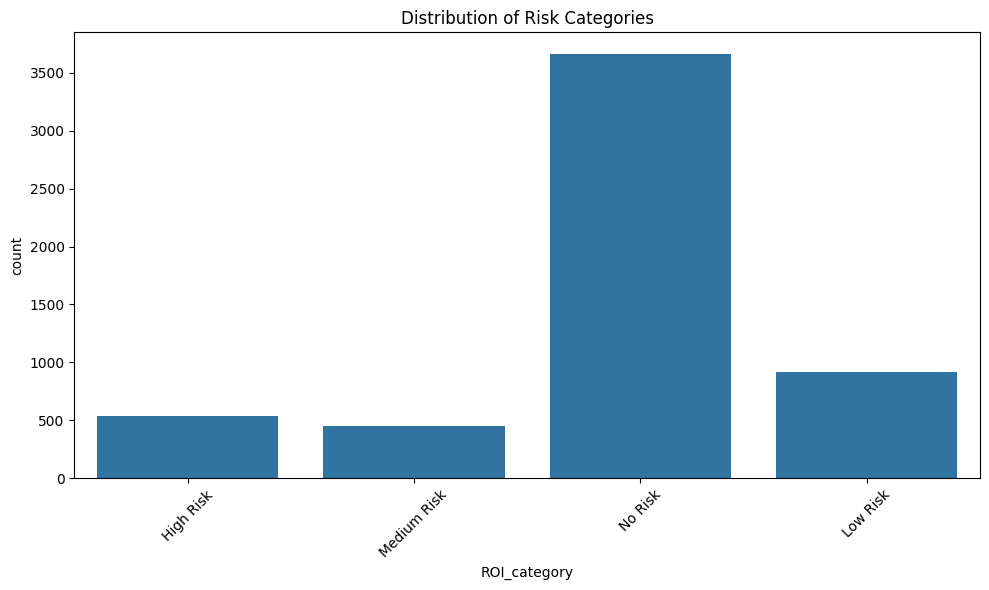

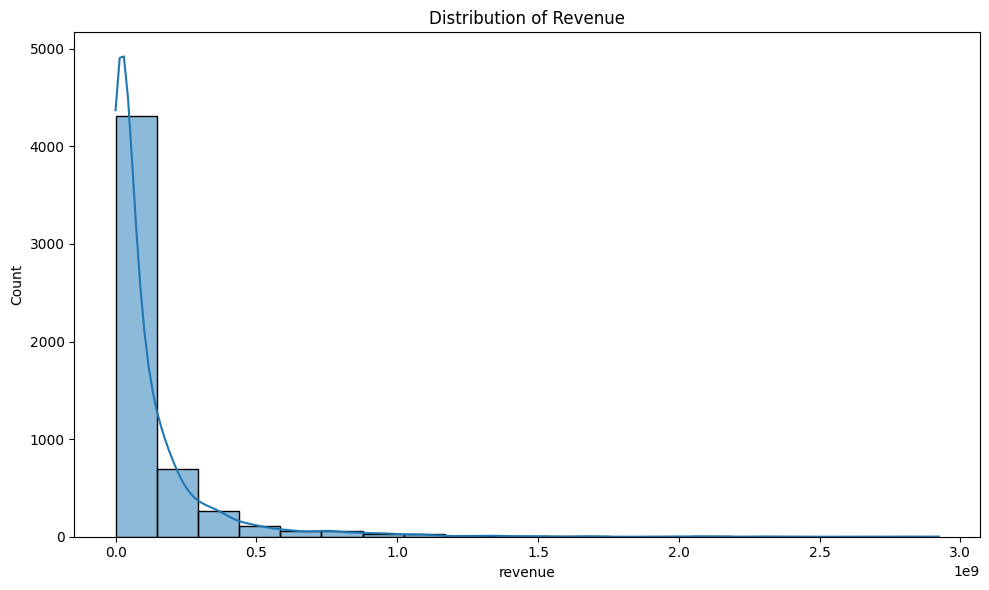

In [57]:
plt.figure(figsize=(10, 6))
sns.countplot(data=processed_df, x='ROI_category')
plt.title('Distribution of Risk Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the distribution of revenue
plt.figure(figsize=(10, 6))
sns.histplot(data=processed_df, x='revenue', bins=20, kde=True)
plt.title('Distribution of Revenue')
plt.tight_layout()
plt.show()


# 4. Model Classes


In [58]:
class RevenueRegressionModel:
    """Base class for revenue regression models"""
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None
        self.feature_importance = None
    
    def train(self, X_train, y_train, param_grid=None, cv=5):
        """
        Train the regression model with optional hyperparameter tuning
        """
        if param_grid:
            # Perform grid search for hyperparameter tuning
            grid_search = GridSearchCV(self.model, param_grid, 
                                      cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            self.model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            print(f"Best parameters for {self.model_name}: {best_params}")
        else:
            # Train with default parameters
            self.model.fit(X_train, y_train)
            best_params = "Default parameters used"
        
        # Calculate feature importance
        if hasattr(self.model, 'feature_importances_'):
            self.feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
        
        # Training metrics
        y_pred_train = self.model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        train_r2 = r2_score(y_train, y_pred_train)
        
        training_metrics = {
            'model_name': self.model_name,
            'train_rmse': train_rmse,
            'train_mae': train_mae,
            'train_r2': train_r2,
            'best_params': best_params
        }
        
        return training_metrics
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on test data
        """
        y_pred = self.model.predict(X_test)
        
        # Calculate metrics
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)
        
        # Create scatter plot of actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Revenue')
        plt.ylabel('Predicted Revenue')
        plt.title(f'{self.model_name} - Actual vs Predicted Revenue')
        plt.show()
        
        evaluation_metrics = {
            'model_name': self.model_name,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2': test_r2
        }
        
        return evaluation_metrics
    
    def save_model(self, model_dir='models/regresi'):
        """
        Save the trained model and feature importance to disk
        """
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model
        model_path = os.path.join(model_dir, f"{self.model_name}.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(self.model, f)
        
        # Save feature importance if available
        if self.feature_importance is not None:
            importance_path = os.path.join(model_dir, f"{self.model_name}_feature_importance.csv")
            self.feature_importance.to_csv(importance_path, index=False)
            
            # Create feature importance plot
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=self.feature_importance.head(10))
            plt.title(f'Top 10 Feature Importance - {self.model_name}')
            plt.tight_layout()
            plt.show()
        
        print(f"{self.model_name} model saved to {model_path}")


# 4.1 Revenue Regression Model

In [59]:
class RandomForestRevenueRegressor(RevenueRegressionModel):
    """Random Forest model for revenue regression"""
    def __init__(self, n_estimators=100, max_depth=None, random_state=42):
        super().__init__("random_forest_regressor")
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state
        )

class XGBoostRevenueRegressor(RevenueRegressionModel):
    """XGBoost model for revenue regression"""
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42):
        super().__init__("xgboost_regressor")
        self.model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=random_state
        )


# 4.2 Risk Classification Model

In [60]:
class RiskClassificationModel:
    """Base class for risk classification models"""
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None
        self.feature_importance = None
        
    def train(self, X_train, y_train, param_grid=None, cv=5):
        """
        Train the classification model with optional hyperparameter tuning
        """
        if param_grid:
            # Perform grid search for hyperparameter tuning
            grid_search = GridSearchCV(self.model, param_grid, 
                                      cv=cv, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            self.model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            print(f"Best parameters for {self.model_name}: {best_params}")
        else:
            # Train with default parameters
            self.model.fit(X_train, y_train)
            best_params = "Default parameters used"
        
        # Calculate feature importance
        if hasattr(self.model, 'feature_importances_'):
            self.feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
        
        # Training metrics
        y_pred_train = self.model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        
        training_metrics = {
            'model_name': self.model_name,
            'train_accuracy': train_accuracy,
            'best_params': best_params
        }
        
        return training_metrics
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on test data
        """
        y_pred = self.model.predict(X_test)
        
        # Calculate metrics
        test_accuracy = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Display confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=np.unique(y_test),
                   yticklabels=np.unique(y_test))
        plt.title(f'{self.model_name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
        
        # Print classification report
        print(f"\nClassification Report for {self.model_name}:")
        print(class_report)
        
        evaluation_metrics = {
            'model_name': self.model_name,
            'test_accuracy': test_accuracy,
        }
        
        return evaluation_metrics
    
    def save_model(self, model_dir='models/klasifikasi'):
        """
        Save the trained model and feature importance to disk
        """
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model
        model_path = os.path.join(model_dir, f"{self.model_name}.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(self.model, f)
        
        # Save feature importance if available
        if self.feature_importance is not None:
            importance_path = os.path.join(model_dir, f"{self.model_name}_feature_importance.csv")
            self.feature_importance.to_csv(importance_path, index=False)
            
            # Create feature importance plot
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=self.feature_importance.head(10))
            plt.title(f'Top 10 Feature Importance - {self.model_name}')
            plt.tight_layout()
            plt.show()
        
        print(f"{self.model_name} model saved to {model_path}")


In [61]:
class RandomForestRiskClassifier(RiskClassificationModel):
    """Random Forest model for risk classification"""
    def __init__(self, n_estimators=100, max_depth=None, random_state=42):
        super().__init__("random_forest_classifier")
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state
        )

class XGBoostRiskClassifier(RiskClassificationModel):
    """XGBoost model for risk classification"""
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42):
        super().__init__("xgboost_classifier")
        self.model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=random_state
        )

# 5. Training and Evaluation


In [62]:
# Split features and targets
X, y_regression, y_classification = split_features_target(processed_df)

# Display feature set
print(f"Features for modeling: {X.columns.tolist()}")
print(f"Number of features: {X.shape[1]}")

# Split into train and test sets
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)
_, _, y_cls_train, y_cls_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Features for modeling: ['release_year', 'release_month', 'budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'lang_en', 'lang_others', 'genre_action', 'genre_adventure', 'genre_animation', 'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family', 'genre_fantasy', 'genre_history', 'genre_horror', 'genre_music', 'genre_mystery', 'genre_romance', 'genre_science_fiction', 'genre_tv_movie', 'genre_thriller', 'genre_war', 'genre_western']
Number of features: 28
Training set size: 4452 samples
Test set size: 1114 samples



# 5.1 Train and evaluate classification models


===== Training Classification Models =====

Training Random Forest Classifier...
Best parameters for random_forest_classifier: {'max_depth': None, 'n_estimators': 100}


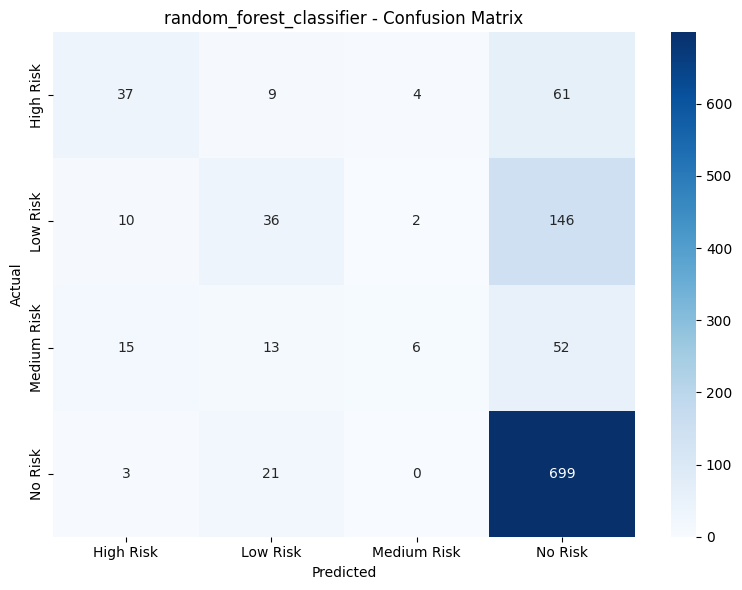


Classification Report for random_forest_classifier:
              precision    recall  f1-score   support

   High Risk       0.57      0.33      0.42       111
    Low Risk       0.46      0.19      0.26       194
 Medium Risk       0.50      0.07      0.12        86
     No Risk       0.73      0.97      0.83       723

    accuracy                           0.70      1114
   macro avg       0.56      0.39      0.41      1114
weighted avg       0.65      0.70      0.64      1114



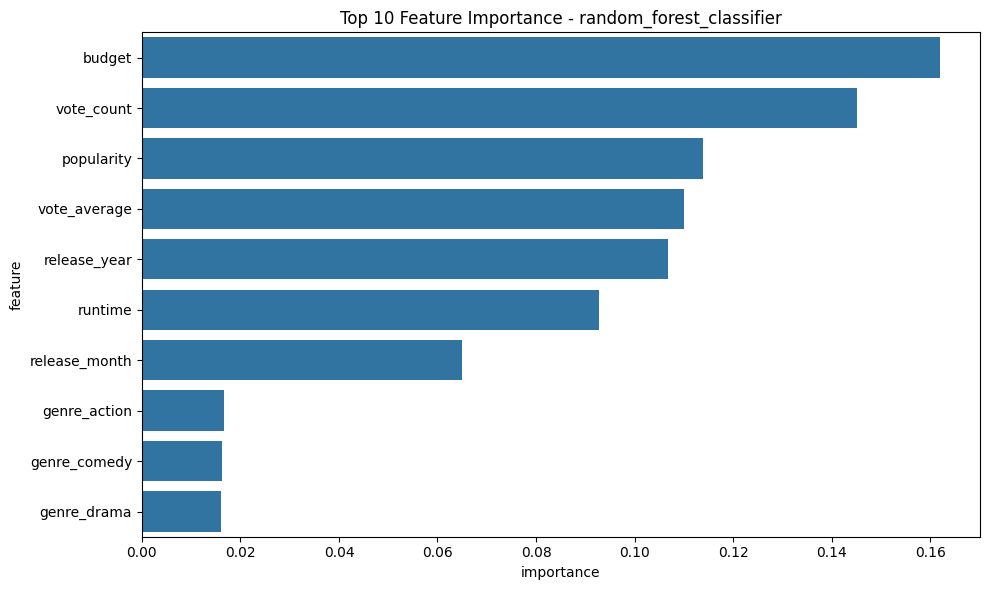

random_forest_classifier model saved to models/klasifikasi\random_forest_classifier.pkl


In [63]:
print("\n===== Training Classification Models =====")
# Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf_classifier = RandomForestRiskClassifier()
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}
rf_cls_train_metrics = rf_classifier.train(X_train, y_cls_train, param_grid=rf_params)
rf_cls_eval_metrics = rf_classifier.evaluate(X_test, y_cls_test)
rf_classifier.save_model()

In [67]:
from sklearn.preprocessing import LabelEncoder

# Buat LabelEncoder untuk ubah label string ke angka
label_encoder = LabelEncoder()

# Fit-transform ke data training
y_cls_train_encoded = label_encoder.fit_transform(y_cls_train)

# Transform juga untuk data testing
y_cls_test_encoded = label_encoder.transform(y_cls_test)



Training XGBoost Classifier...
Best parameters for xgboost_classifier: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


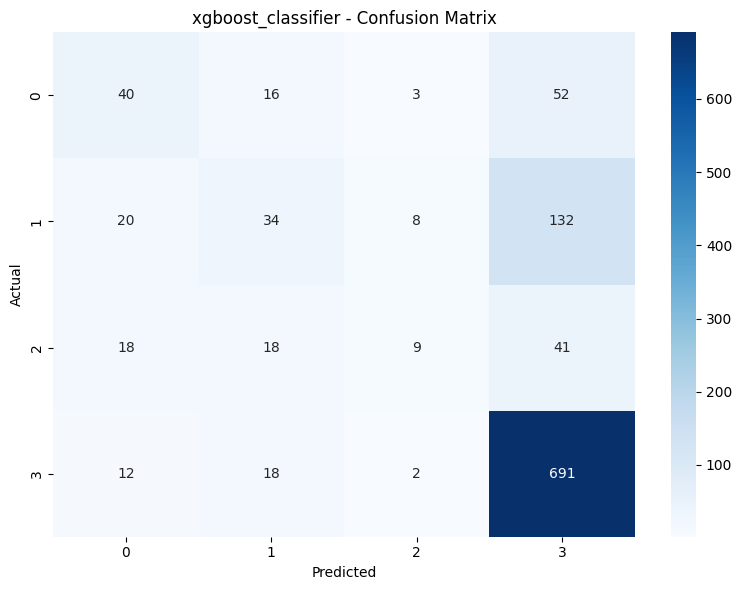


Classification Report for xgboost_classifier:
              precision    recall  f1-score   support

           0       0.44      0.36      0.40       111
           1       0.40      0.18      0.24       194
           2       0.41      0.10      0.17        86
           3       0.75      0.96      0.84       723

    accuracy                           0.69      1114
   macro avg       0.50      0.40      0.41      1114
weighted avg       0.63      0.69      0.64      1114



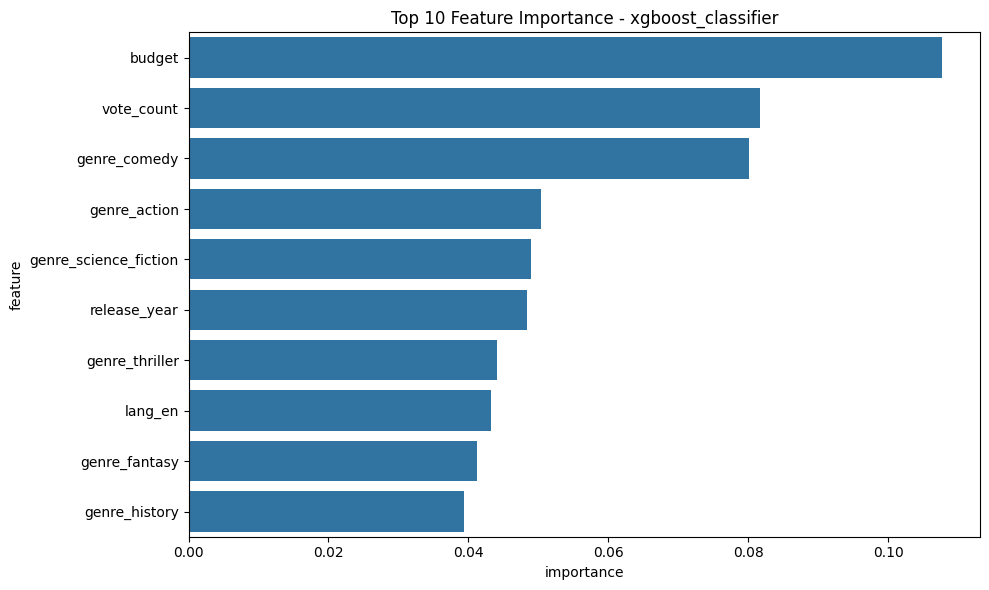

xgboost_classifier model saved to models/klasifikasi\xgboost_classifier.pkl


In [ ]:
# XGBoost Classifier
print("\nTraining XGBoost Classifier...")
xgb_classifier = XGBoostRiskClassifier()
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}


xgb_cls_train_metrics = xgb_classifier.train(X_train, y_cls_train_encoded, param_grid=xgb_params)
xgb_cls_eval_metrics = xgb_classifier.evaluate(X_test, y_cls_test_encoded)
xgb_classifier.save_model()



# 5.2 Train and evaluate regression models


===== Training Regression Models =====

Training Random Forest Regressor...
Best parameters for random_forest_regressor: {'max_depth': None, 'n_estimators': 100}


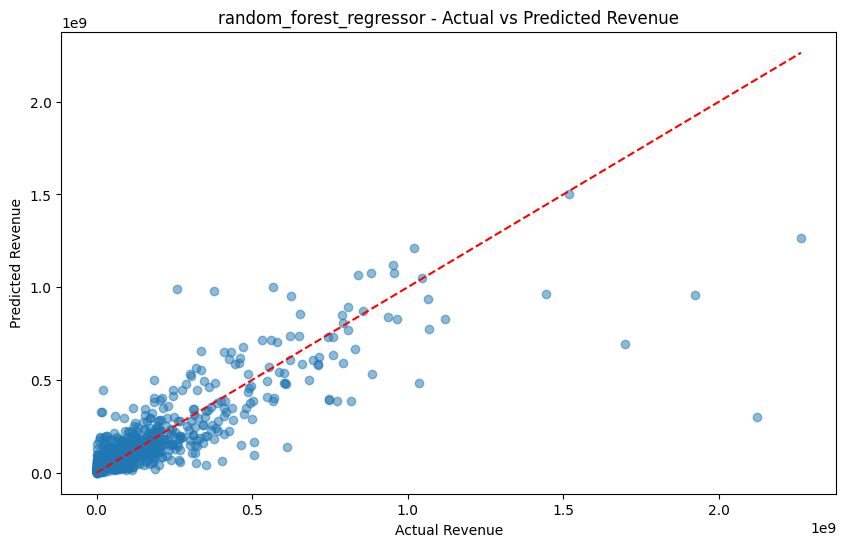

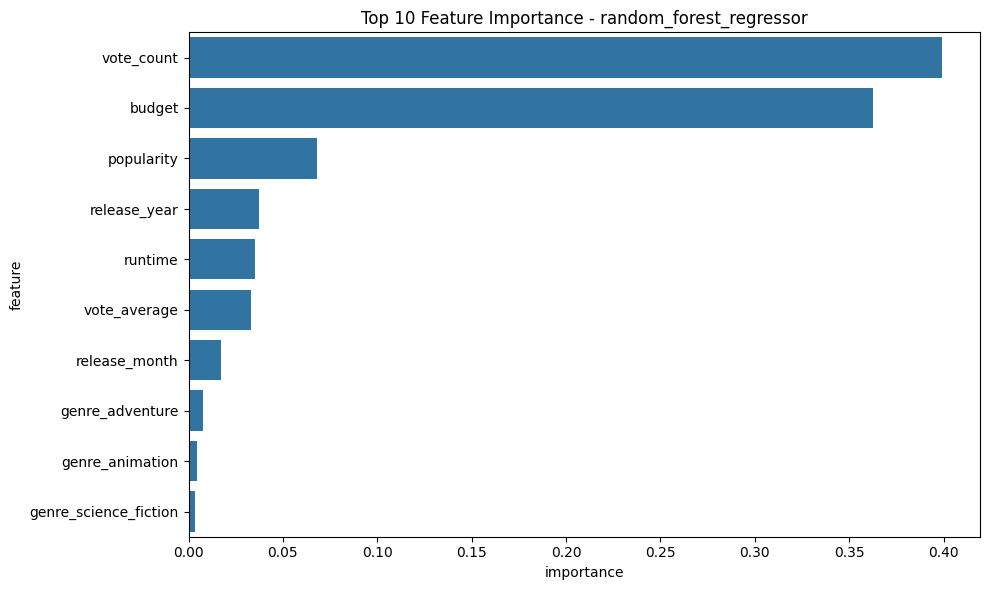

random_forest_regressor model saved to models/regresi\random_forest_regressor.pkl


In [65]:
print("\n===== Training Regression Models =====")
# Random Forest Regressor
print("\nTraining Random Forest Regressor...")
rf_regressor = RandomForestRevenueRegressor()
rf_reg_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}
rf_reg_train_metrics = rf_regressor.train(X_train, y_reg_train, param_grid=rf_reg_params)
rf_reg_eval_metrics = rf_regressor.evaluate(X_test, y_reg_test)
rf_regressor.save_model()


Training XGBoost Regressor...
Best parameters for xgboost_regressor: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


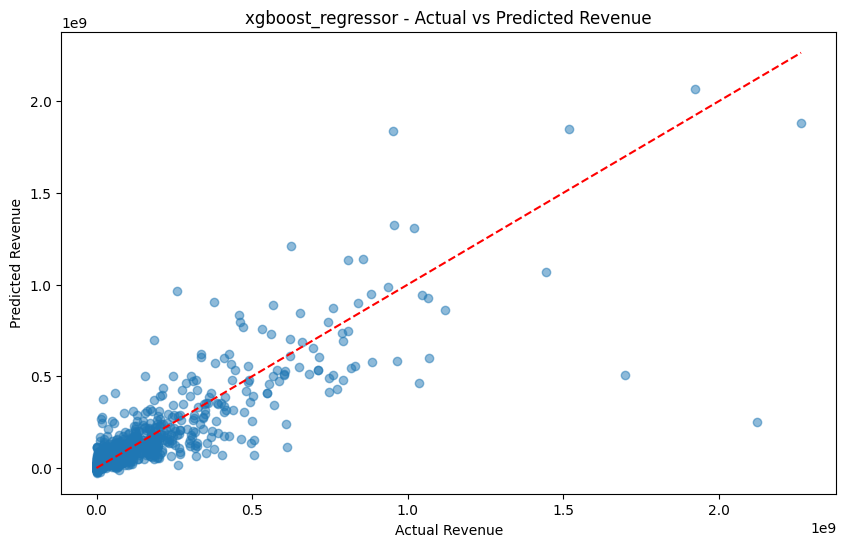

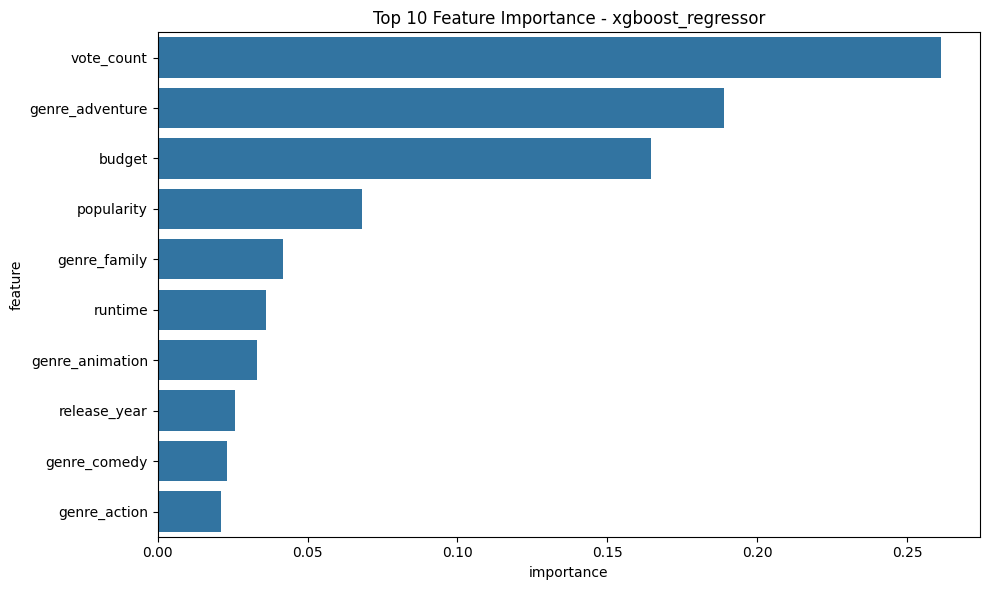

xgboost_regressor model saved to models/regresi\xgboost_regressor.pkl


In [66]:
# XGBoost Regressor
print("\nTraining XGBoost Regressor...")
xgb_regressor = XGBoostRevenueRegressor()
xgb_reg_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}
xgb_reg_train_metrics = xgb_regressor.train(X_train, y_reg_train, param_grid=xgb_reg_params)
xgb_reg_eval_metrics = xgb_regressor.evaluate(X_test, y_reg_test)
xgb_regressor.save_model()

# 6. Model Comparison

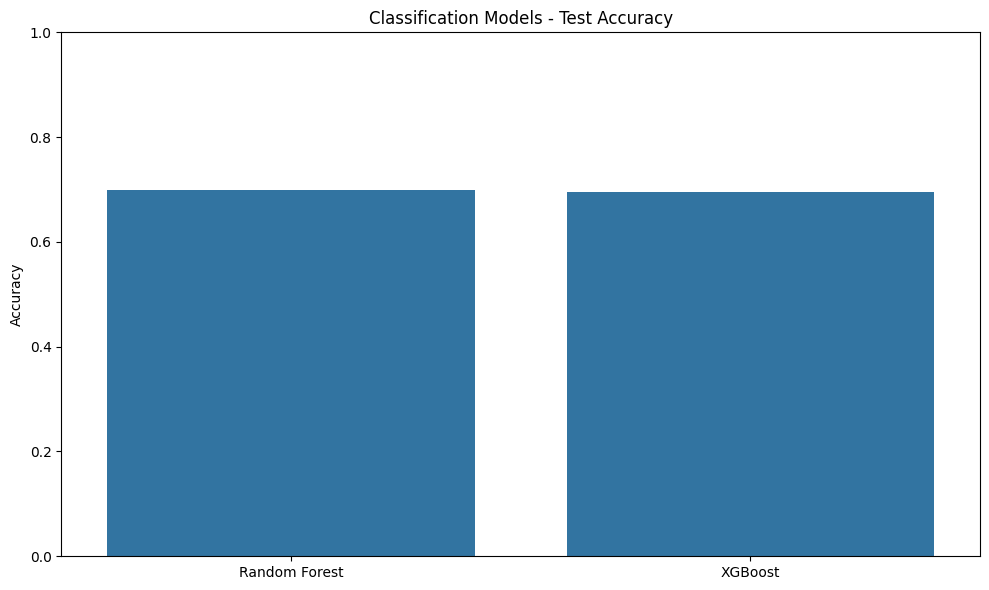

In [69]:
# Compare classification models
cls_models = ["Random Forest", "XGBoost"]
cls_accuracy = [
    rf_cls_eval_metrics['test_accuracy'],
    xgb_cls_eval_metrics['test_accuracy']
]

plt.figure(figsize=(10, 6))
sns.barplot(x=cls_models, y=cls_accuracy)
plt.title('Classification Models - Test Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

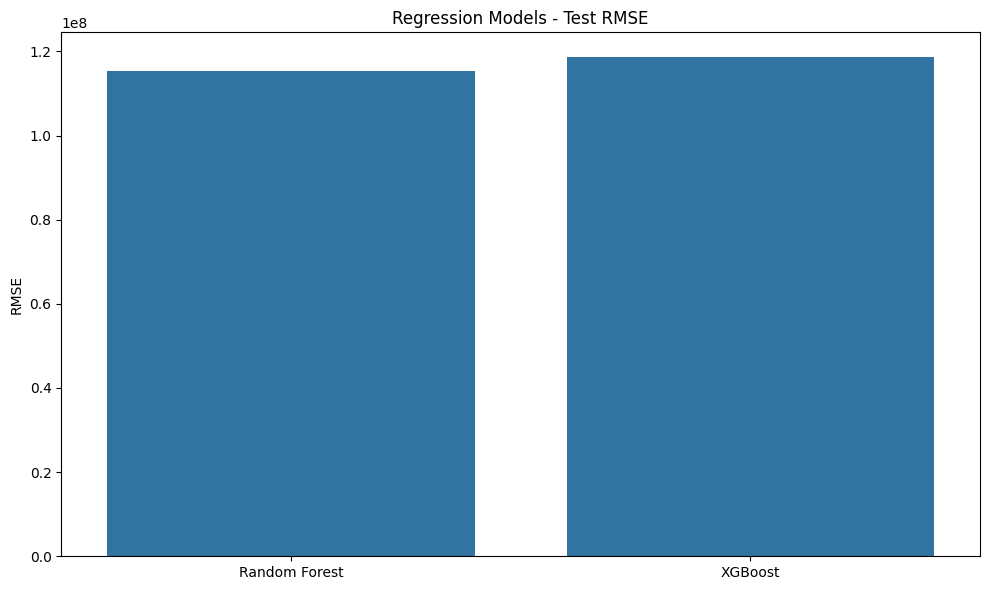

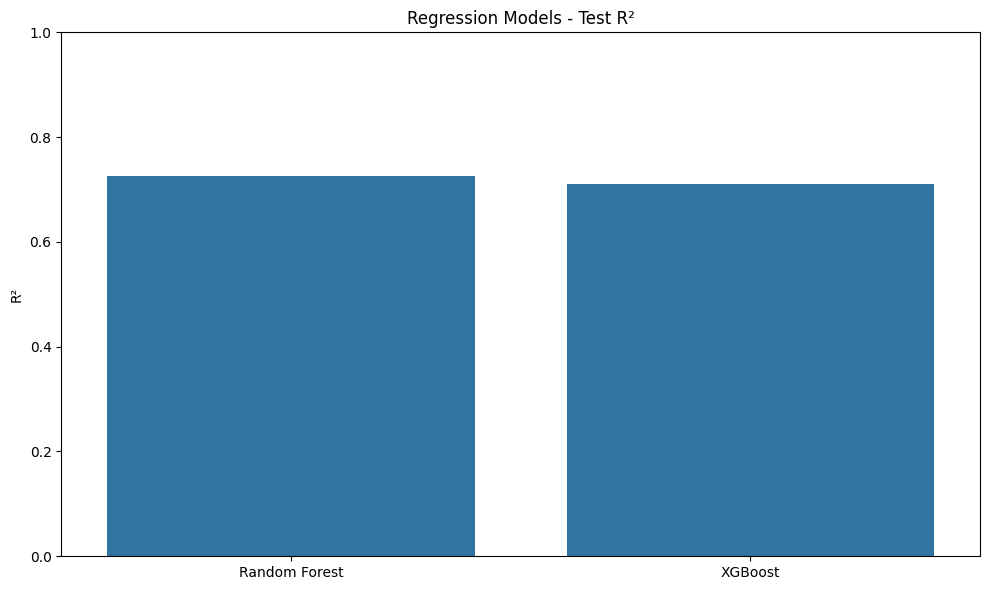

In [70]:
# Compare regression models
reg_models = ["Random Forest", "XGBoost"]
reg_rmse = [
    rf_reg_eval_metrics['test_rmse'],
    xgb_reg_eval_metrics['test_rmse']
]
reg_r2 = [
    rf_reg_eval_metrics['test_r2'],
    xgb_reg_eval_metrics['test_r2']
]

plt.figure(figsize=(10, 6))
sns.barplot(x=reg_models, y=reg_rmse)
plt.title('Regression Models - Test RMSE')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=reg_models, y=reg_r2)
plt.title('Regression Models - Test R²')
plt.ylim(0, 1)
plt.ylabel('R²')
plt.tight_layout()
plt.show()

# 7. Making Predictions on New Data


In [ ]:
def predict(input_data, output_file_path=None):
    """
    Generate predictions using trained models
    
    Args:
        input_data: DataFrame with movie features
        output_file_path: Path to save predictions (optional)
    
    Returns:
        DataFrame with predictions
    """
    # Preprocess data
    processed_df = preprocess_data(input_data)
    
    # Extract features
    X, _, _ = split_features_target(processed_df)
    
    # Load best models (We'll use the ones we just trained)
    regression_model = xgb_regressor
    classification_model = xgb_classifier
    
    # Generate predictions
    print("Generating predictions...")
    revenue_predictions = regression_model.model.predict(X)
    risk_predictions = classification_model.model.predict(X)
    
    # Create result dataframe
    results_df = input_data.copy()
    results_df['predicted_revenue'] = revenue_predictions
    results_df['predicted_risk'] = risk_predictions
    
    # Calculate predicted ROI
    results_df['predicted_roi'] = ((results_df['predicted_revenue'] - results_df['budget']) / results_df['budget']) * 100
    
    # Create feature importance dictionary
    feature_importance = {}
    if hasattr(regression_model, 'feature_importance') and regression_model.feature_importance is not None:
        for _, row in regression_model.feature_importance.iterrows():
            feature_importance[row['feature']] = row['importance']
    
    results_df['feature_importance'] = str(feature_importance)
    
    # Save predictions if output path is provided
    if output_file_path:
        print(f"Saving predictions to {output_file_path}...")
        results_df.to_csv(output_file_path, index=False)
    
    return results_df

# Let's test our predictions on a sample of our test data
sample_data = df.iloc[:5].copy()
predictions = predict(sample_data, "sample_predictions.csv")

# Display predictions
print("\nPrediction Results:")
for i, row in predictions.iterrows():
    print(f"\nSample {i+1}:")
    print(f"Budget: ${row['budget']:,}")
    print(f"Predicted Revenue: ${row['predicted_revenue']:,.2f}")
    print(f"Predicted ROI: {row['predicted_roi']:.2f}%")
    print(f"Risk Level: {row['predicted_risk']}")

# 8. Conclusion


In [71]:
print("\nModel Performance Summary:")
print("\nClassification Models:")
print(f"  Random Forest Accuracy: {rf_cls_eval_metrics['test_accuracy']:.4f}")
print(f"  XGBoost Accuracy: {xgb_cls_eval_metrics['test_accuracy']:.4f}")

print("\nRegression Models:")
print(f"  Random Forest RMSE: {rf_reg_eval_metrics['test_rmse']:.2f}")
print(f"  Random Forest R²: {rf_reg_eval_metrics['test_r2']:.4f}")
print(f"  XGBoost RMSE: {xgb_reg_eval_metrics['test_rmse']:.2f}")
print(f"  XGBoost R²: {xgb_reg_eval_metrics['test_r2']:.4f}")

# Find the best models
best_classifier = "XGBoost" if xgb_cls_eval_metrics['test_accuracy'] > rf_cls_eval_metrics['test_accuracy'] else "Random Forest"
best_regressor = "XGBoost" if xgb_reg_eval_metrics['test_r2'] > rf_reg_eval_metrics['test_r2'] else "Random Forest"

print(f"\nBest Classification Model: {best_classifier}")
print(f"Best Regression Model: {best_regressor}")


Model Performance Summary:

Classification Models:
  Random Forest Accuracy: 0.6984
  XGBoost Accuracy: 0.6948

Regression Models:
  Random Forest RMSE: 115441844.92
  Random Forest R²: 0.7253
  XGBoost RMSE: 118610849.72
  XGBoost R²: 0.7100

Best Classification Model: Random Forest
Best Regression Model: Random Forest
